<a href="https://colab.research.google.com/github/ginomempin/machine-learning-tutorials/blob/master/src/Algorithms/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.nn import Linear

# Algorithm Overview

Given this equation for a line:

y = wx + b

where:  
* **w** is the slope
* **b** is the bias or y-intercept

The task is to create a model that, given a data set of points, can "learn"
the correct equation for a line (i.e. get the optimal values for **w** and **b**) that will fit the said data set of points.

# Defining the Model (Manual Way)

In [0]:
# First, we set the slope and bias to some random values we assume would
# make the line fit the given data set.
# Eventually, the model should arrive at the correct values.
w = torch.tensor(3.0, requires_grad=True)  
b = torch.tensor(1.0, requires_grad=True)

In [0]:
# Define the forward function that predicts the value based on an input x.
def forward(x):
    y = w*x + b 
    return y

In [0]:
# Check the computations of the forward function.

# Can pass single inputs
x = torch.tensor(2)
print(forward(x))

# Can pass many inputs
x = torch.tensor([ [4], [7] ])
print(forward(x))

tensor(7., grad_fn=<AddBackward0>)
tensor([[13.],
        [22.]], grad_fn=<AddBackward0>)


# Defining the Model (Using Linear Class)

In [0]:
torch.manual_seed(1)
# This is necessary because the model will be assigned random values
# for the weight (w) and bias (b). The seed can be any value, as long
# you are consistently using the same seed for training.

model = Linear(in_features=1, out_features=1)
# For every 1 output, there is a 1 corresponding input.

print(model.weight) # corresponds to the 'w' param
print(model.bias)   # corresponds to the 'b' param

Parameter containing:
tensor([[0.5153]], requires_grad=True)
Parameter containing:
tensor([-0.4414], requires_grad=True)


In [0]:
x = torch.tensor([2.0])
model(x)

tensor([0.5891], grad_fn=<AddBackward0>)

In [0]:
x = torch.tensor([[2.0], [3.3]])
model(x)

tensor([[0.5891],
        [1.2590]], grad_fn=<AddmmBackward>)

# Defining the Model (OOP Approach)

In [0]:
# Linear Regression Module
#
# Wraps PyTorch's Linear module, configuring the
# required params to setup and use a Linear model.
class LR(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self._linear = nn.Linear(in_features=input_size,
                                out_features=output_size)

    def print_params(self):
        print(list(self.parameters()))

    def forward(self, x: torch.Tensor):
        return self._linear(x)

In [0]:
torch.manual_seed(1)

model = LR(1, 1)
print(model)

model.print_params()  
# This should show same result as in "Using Linear Class" section.

x = torch.tensor([2.0])
print(model.forward(x))
# This should show same result as in "Using Linear Class" section.

x = torch.tensor([[2.0], [3.3]])
print(model.forward(x))
# This should show same result as in "Using Linear Class" section.

LR(
  (_linear): Linear(in_features=1, out_features=1, bias=True)
)
[Parameter containing:
tensor([[0.5153]], requires_grad=True), Parameter containing:
tensor([-0.4414], requires_grad=True)]
tensor([0.5891], grad_fn=<AddBackward0>)
tensor([[0.5891],
        [1.2590]], grad_fn=<AddmmBackward>)


# Creating the Data Set

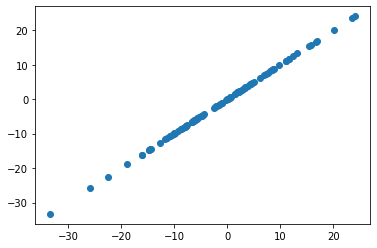

In [0]:
# Generate a Tensor filled with random numbers that are normally distributed.
# Let the Tensor have 100 rows and 1 column, where the column represents the
# single value within the normal distribution.
x_data = 10 * torch.randn(100, 1)   # Make it plottable by scaling values by 10
y_data = x_data

plt.plot(x_data.numpy(), y_data.numpy(), 'o')

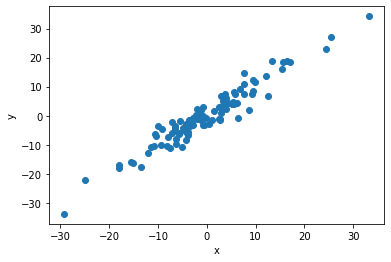

In [0]:
# The previous plot already shows a linear data set, which would be "easy"
# for the model to "learn". Make it difficult by adding "noise" values to
# the resulting y value.
x_data = 10 * torch.randn(100, 1)
y_data = x_data + (3 * torch.randn(100, 1))

plt.ylabel('y')
plt.xlabel('x')
plt.plot(x_data.numpy(), y_data.numpy(), 'o') 

# Plotting the Initial Model vs. the Data Set

In [0]:
# Initial prediction of a model

torch.manual_seed(1)
model = LR(1, 1) 

w, b = model.parameters()  
print(w)
print(b)

Parameter containing:
tensor([[0.5153]], requires_grad=True)
Parameter containing:
tensor([-0.4414], requires_grad=True)


In [0]:
w1 = w[0][0]
print(w1)           # should now be a basic Tensor type
print(w1.item())    # get the raw value

b1 = b[0]
print(b1)           # should not be a basic Tensor type
print(b1.item())    # get the raw value

tensor(0.5153, grad_fn=<SelectBackward>)
0.5152631998062134
tensor(-0.4414, grad_fn=<SelectBackward>)
-0.44137823581695557


In [0]:
def get_params():
    return (
        w[0][0].item(),
        b[0].item()
    )

def plot_fit(title):
    plt.title = title
    w1, b1 = get_params()
    x1 = np.array([-30, 30])    # based on the plot of the data set
    y1 = (w1 * x1) + b1
    plt.plot(x1, y1, 'r')
    plt.scatter(x_data, y_data)
    plt.show()

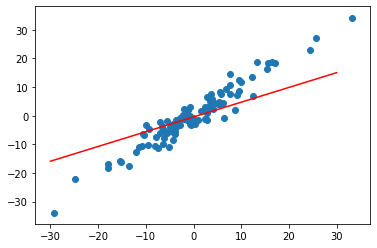

In [0]:
plot_fit("Initial Model")

Clearly the initial Linear model does not match the data set. This is caused by assigning random weights and biases when setting-up the Linear model. We need to adjust these parameters based on the total error until we get a Linear model with suitable parameters.

# Loss Function

The Loss Function is defined as:

> <strong>LOSS = (y<sub>1</sub> - y<sub>0</sub>)<sup>2</sup></strong>  
where:
* y<sub>1</sub> is the correct value
* y<sub>0</sub> is current prediction value

The closer the prediction value is to the correct value, the smaller the error.

We know that y<sub>0</sub> = wx + b:

> <strong>LOSS = (y<sub>1</sub> - (wx + b))<sup>2</sup></strong>  

The **b** here (the y-intercept, the point on the y-axis intersected by the line) indicates an infinite number of lines can be drawn that results in LOSS~0. 

So, let's fix **b=0** to only consider the lines passing through the origin (y=0).

> <strong>LOSS = (y<sub>1</sub> - wx)<sup>2</sup></strong>  

Given a data point **(-3, 3)**:

> <strong>LOSS = (3 - (-3w))<sup>2</sup></strong>  

The LOSS (or error) depends on the weight (or slope) value.


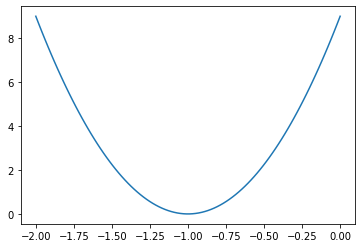

In [0]:
w_possibles = torch.linspace(start=-2.0, end=0.0, steps=100)
loss_result = pow(3 - (-3 * w_possibles), 2)

plt.plot(w_possibles.numpy(), loss_result.numpy())

We can see that the minimum LOSS happens at w=-1.00.

# Gradient Descent

From the initial line produced by the model (initialized with a random weight/slope **w** and bias/y-intercept **b**), we want it to move *towards* the direction where the loss/error function is approaching zero.

The trick is getting the gradient or the derivative of the loss function, which indicates the rate at which it changes. If rate of change is becoming vertical (i.e. towards +8 in the graph above), then it means the error rate is increasing. If the rate of change is becoming horizontal (i.e. towards 0) then the error rate is decreasing.

Given the previous loss function:

> <strong>LOSS = (3 - (-3w))<sup>2</sup></strong>

The derivative is:

> <strong>LOSS = (3 + 3w)<sup>2</sup></strong>  
> <strong>LOSS = 9 + 9w + 9w + 9w<sup>2</sup></strong>  
> <strong>LOSS = 9 + 18w + 9w<sup>2</sup></strong>  
> <strong>LOSS' = 18 + 18w</strong>  
> <strong>LOSS' = 18(w + 1)</strong>

In summary, first compute the derivative of the loss function. Then substitute the current weight value of the line. That will give the current gradient value.

Then, this current gradient value is subtracted from the current weight (w<sub>0</sub>) to get the new updated weight (w<sub>1</sub>):

> <strong>w<sub>1</sub> = w<sub>0</sub> - LOSS'</strong>

The new weight should result in a smaller error than the previous one. We keep doing this iteratively until we obtain a smallest error and the optimal parameters for the model to fit the date.

As we try to get the optimal gradient value, we need to iterate in very small steps, because we don't want it to move too drastically in one direction. To do that, we need to multiply **LOSS'** by a small value, called the **learning rate (&alpha;)**.

> <strong>w<sub>1</sub> = w<sub>0</sub> - &alpha; * LOSS'</strong>

See this ![sample visualization using Excel](https://github.com/ginomempin/machine-learning-tutorials/blob/master/src/Algorithms/LinearRegression-GradientDescentSimulation.png).

Basically, the gradient is like a compass, pointing us in the direction of the smallest error.

# Mean Squared Error

The mean squared error is calculated the same way as the loss function, but this time, the bias value (i.e. the y-intercept of the linear equation) will also be considered since it is also a parameter that needs to be optimized during training.

See the [formula for Mean Squared Error](https://github.com/ginomempin/machine-learning-tutorials/blob/master/src/Algorithms/LinearRegression-MeanSquaredError.jpg).

The steps to calculate will not be shown here, but it is generally the same steps as with the **LOSS** function:

1. Substitute the (y = wx+b) formula for the current predicted value y<sub>0</sub>
1. Get the partial derivatives with respect to **w** and with respect to **b**
1. Get the current gradient value
1. Get the new weight by subtracting the current gradient value from the current weight
1. Iteratively repeat the previous steps until we get an error that approaches zero

> <strong>w<sub>1</sub> = w<sub>0</sub> - &alpha; * LOSS'</strong>  
> <strong>b<sub>1</sub> = b<sub>0</sub> - &alpha; * LOSS'</strong>

# How to do all this math???

PyTorch actually does all this math for us under the hood.

The basic idea is:

1. Initialize a model with a random set of weight and bias parameters
1. Calcuate the loss/error between current and correct model outputs
1. Use gradient descent to update the weight and bias parameters
1. Repeat until we approach an error close to zero


# THE CODE

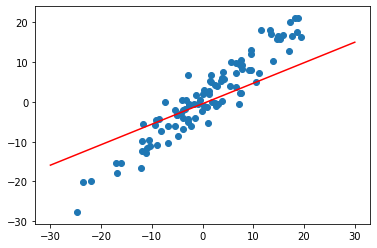

In [0]:
# Define the data set
x_data = 10 * torch.randn(100, 1)
y_data = x_data + (3 * torch.randn(100, 1))

# Initialize a model

class LR(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self._linear = nn.Linear(in_features=input_size,
                                out_features=output_size)
    def forward(self, x: torch.Tensor):
        return self._linear(x)

torch.manual_seed(1)
model = LR(1, 1)
def get_params():
    w, b = model.parameters()
    w0 = w[0][0].item()
    b0 = b[0].item()
    return w0, b0

# Check the intial output of the model
def plot_fit(title):
    plt.title = title
    wp, bp = get_params()
    xp = np.array([-30, 30])    # based on the plot of the data set
    yp = (wp * xp) + bp
    plt.plot(xp, yp, 'r')
    plt.scatter(x_data, y_data)
    plt.show()

plot_fit("Initial")

In [0]:
# TRAINING! 

# We want our loss to approach zero
criterion = nn.MSELoss()        

# We will use Stochastic Gradient Descent
optimizer = torch.optim.SGD(
                model.parameters(),
                lr=0.01)

# Define how many passes on the data set
# Too few epochs can lead to underfitting
# Too many epochs can lead to overfitting
epochs = 100

# Note: 
#   When running in Google Colab and getting weird
#   values for loss, try restarting the Runtime.
losses = []
for i in range(epochs):
    # Get current model output
    y_pred = model.forward(x_data)

    # Calculate the loss
    loss = criterion(y_pred, y_data)
    print("epoch: {}, loss: {}".format(i, loss.item()))
    losses.append(loss)

    # Get the gradient/derivative of the loss function
    optimizer.zero_grad()   
    loss.backward()

    # Update the model parameters
    optimizer.step()


Text(0.5, 0, 'epoch')

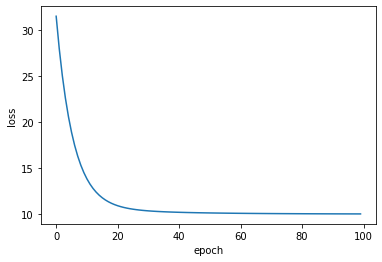

In [0]:
plt.plot(range(epochs), losses)
plt.ylabel("loss")
plt.xlabel("epoch")

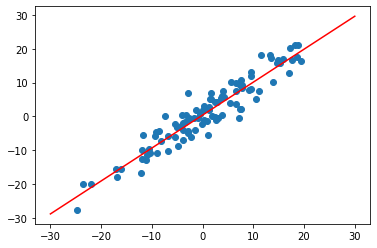

In [0]:
# Check the trained output of the model
plot_fit("Trained")